# Real-World Example: Tehran House Price Prediction 

### For this section, we will use regression to predict house prices in different regions of Tehran. The [Dataset](https://www.kaggle.com/datasets/mokar2001/house-price-tehran-iran) used is records on Divar website.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

In [18]:
! pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
file_path = 'C:/Users/golde/OneDrive/Desktop/learning/Introduction_to_Machine_Learning/Chapter_01_Supervised_Learning/assets/housePrice.xlsx'
df = pd.read_excel(file_path)

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,PriceUSD
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33


In [25]:
print(df['Area'].describe())
print(df[df['Area'] > 1e6])

count    3.479000e+03
mean     8.744000e+06
std      3.167266e+08
min      3.000000e+01
25%      6.900000e+01
50%      9.000000e+01
75%      1.200000e+02
max      1.616000e+10
Name: Area, dtype: float64
             Area  Room  Parking  Warehouse  Elevator            Address  \
570    3310000000     2     True       True      True        Ostad Moein   
709   16160000000     3     True       True      True           Pasdaran   
1604   8400000000     2     True       True      True         Gheitarieh   
2802   2550000000     2     True       True      True  Central Janatabad   

            Price   PriceUSD  
570    3310000000  110333.33  
709   16160000000  538666.67  
1604   8700000000  290000.00  
2802   2550000000   85000.00  


In [ ]:
# Data cleaning - removing outliers based on IQR



lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

df_cleaned = df[(df['Area'] >= lower_bound_area) & (df['Area'] <= upper_bound_area) &
                (df['PriceUSD'] >= lower_bound_price) & (df['PriceUSD'] <= upper_bound_price)]

# Check the cleaned dataset
df_cleaned.describe()


,Area,Room,Price,PriceUSD
count,3112.000000,3112.000000,3.112000e+03,3112.000000
mean,90.353470,1.948265,3.393833e+09,113127.752988
std,30.790158,0.638090,2.844133e+09,94804.436318
min,30.000000,0.000000,3.600000e+06,120.000000
25%,66.000000,2.000000,1.250000e+09,41666.670000
50%,86.000000,2.000000,2.450000e+09,81666.670000
75%,109.000000,2.000000,4.500000e+09,150000.000000
max,192.000000,5.000000,1.282500e+10,427500.000000


In [29]:
# Data cleaning - removing outliers based on IQR
Q1_area = df['Area'].quantile(0.25)
Q3_area = df['Area'].quantile(0.75)
IQR_area = Q3_area - Q1_area

Q1_price = df['PriceUSD'].quantile(0.25)
Q3_price = df['PriceUSD'].quantile(0.75)
IQR_price = Q3_price - Q1_price


lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_area + 1.5 * IQR_price

df_cleaned = df[(df['Area'] >= lower_bound_area) & (df['Area'] <= upper_bound_area) &
                (df['PriceUSD'] >= lower_bound_price) & (df['PriceUSD'] <= upper_bound_price)]


#check the cleaned dataset
df_cleaned.describe()

,Area,Room,Price,PriceUSD
count,2696.000000,2696.000000,2.696000e+03,2696.000000
mean,83.572329,1.850519,2.486101e+09,82870.017511
std,25.439585,0.593333,1.659879e+09,55329.293264
min,30.000000,0.000000,3.600000e+06,120.000000
25%,65.000000,2.000000,1.100000e+09,36666.670000
50%,81.000000,2.000000,2.150000e+09,71666.670000
75%,100.000000,2.000000,3.500000e+09,116666.670000
max,180.000000,5.000000,6.850000e+09,228333.330000


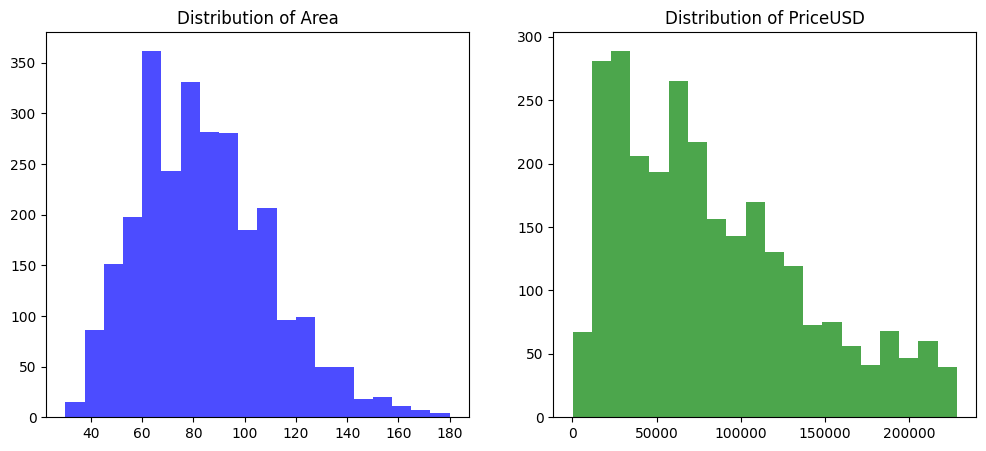

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df_cleaned['Area'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Area')

plt.subplot(1,2,2)
plt.hist(df_cleaned['PriceUSD'], bins=20, color='green', alpha=0.7)
plt.title('Distribution of PriceUSD')

plt.show()

In [ ]:
# Function to compute the Root Mean Squared Error (RMSE)
def compute_rms_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# function to creat polynomial features
def polynomial_features(X, degree):
    poly = PolynomialFeatures(degree=degree)
    return poly.fit_transform(X)

# Function to perform polynomial regression
def polynomial_regression(X, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly,y)
    return model